# Detecting Art Forgeries Using Machine Learning
Classifying craquelure (cracks due to old age) patterns in classical oil paintings

## Table of Contents
1. <a href ='#goal'>Problem Statement</a>
2. <a href='#terms'>Key Terminology</a>
3. <a href='#datasources'>Data Sources</a>
4. <a href='#EDA'>Exploratory Data Analysis/Image Preprocessing</a>
5. <a href='#models'>Image Classification Using CNN</a>
 1. <a href='#model1'>Model on Greyscale Images</a> 
 2. <a href='#model2'>Model on Color Images</a>
 3. <a href='#model3'>Model on Black and White Images</a>
6. <a href='#findings'>Findings</a>
7. <a href='#recs'>Next Steps</a>

In [24]:
# Import libraries & set defaults
import zipfile
import boto3
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
import cv2
from keras import models, layers 
from keras.optimizers import Adam
from keras.callbacks import callbacks
from keras.models import load_model
np.random.seed(123)

Using TensorFlow backend.


<a id='goal'></a>
## Problem Statement

Art forgery has always been a problem that costs exorbitant amounts of money to art collectors and institutes like museums. Until very recently, art forgery detection has depended on unreliable, expensive and time-consuming technology and human expertise. 

However, over the past few years, machine learning experts have been exploring ways to simplify this process by classifying line strokes ad brush strokes by specific artists.

This project aims to contribute to the efforts in art forgery detection by classifying patterns in craquelure (cracks due to old age) by region in classical oil paintings. Oil paintings have different craquelure patterns depending on the time period and region they were created. Being able to classify when and/or where a painting is or is not from could add valuable information to determining whether a piece of work is authentic or a fake/forgery.

Due to the time constraints and limited resources, this project specifically looked at:

* 17th century
* Oil on canvas
* Dutch vs. Flemish paintings

<a id='terms'></a>
## Key Terminology

- **Craquelure**: cracks in paintings due to old age (different from cracks due to drying)
- **Flemish**: of or relating to Flanders, the Flemish Region of Belgium (northern Belgium)

<a id='datasources'></a>
## Data Sources

### The National Gallery of Art
(https://www.nga.gov/collection/collection-search.html)

- Full paintings from which craquelure images were extracted are in data/Full Paintings folder in this repo (the actual high resolution images are on the National Gallery of Art website above)
- Craquelure images used for modeling are available for download as a zipfile in the AWS S3 bucket: [art.forgery.capstone.project](https://s3.console.aws.amazon.com/s3/buckets/art.forgery.capstone.project/?region=us-east-1&tab=overview)

In [24]:
%run py_files/get_data

In [26]:
get_zipfile('art.forgery.capstone.project', 'Cracks.zip', 'data/Cracks.zip')
unzip('data/Cracks.zip')

<a id='EDA'></a>
## Exploratory Data Analysis / Image Preprocessing

In [18]:
%run py_files/eda

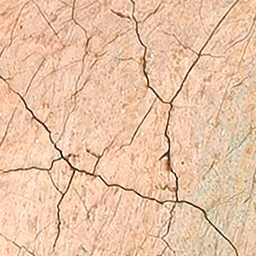

In [3]:
# Looking at a sample original/color image
load_img('sample_cracks_eda/Screen Shot 2020-01-09 at 1.02.27 PM.png')

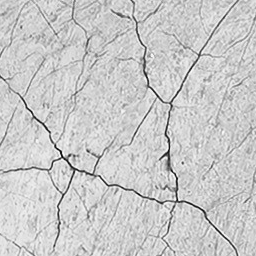

In [28]:
# Looking at a sample grayscaled image
load_img('sample_cracks_eda/Screen Shot 2020-01-09 at 1.02.27 PM.png', grayscale=True)

In [ ]:
## To save grayscale image and open image in separate window
# grayscale('sample_cracks_eda/Screen Shot 2020-01-09 at 1.02.27 PM.png')

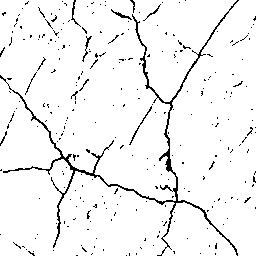

In [12]:
# Looking at a sample black & white image - may need to change threshold number depending on input image
bw_image = binarize_image(img_path='sample_cracks_eda/Screen Shot 2020-01-09 at 1.02.27 PM.png', threshold=155)
Image.fromarray(bw_image)

In [13]:
## To save b&w image
# bwimage = Image.fromarray(data)
# bwimage.save('insert_new_file_name')

In [22]:
## To invert b&w images that have black background and white lines gathered in a folder/directory
# invert_image('insert_directory_path')

<a id='models'></a>
## Image Classification Using CNN

<a id='model1'></a>
## 1) Model on Grayscale Images

In [28]:
# Directory path
train_data_dir = 'data/Cracks/train'
test_data_dir = 'data/Cracks/test'

# Get all the data in the directory data/test and grayscale
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(256, 256), batch_size=463, color_mode='grayscale')

# Get all the data in the directory data/train and grayscale
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), batch_size=1806, color_mode='grayscale')

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 463 images belonging to 2 classes.
Found 2510 images belonging to 2 classes.


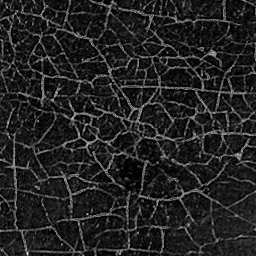

In [29]:
# Previewing an image for checking
array_to_img(train_images[15])

<a id='model2'></a>
## 2) Model on Color Images

<a id='model3'></a>
## 3) Model on Black and White Images

<a id='findings'></a>
## Findings

<a id='recs'></a>
## Next Steps